In [2]:
import os

import pandas as pd
import numpy as np
import numpy.linalg as nla
import matplotlib.pyplot as plt

from scipy.sparse import save_npz, load_npz
from joblib import dump, load

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

import re

import treelib

from collections import Counter, defaultdict

import abs_tag_lib as at

# Abstract classification (supervised learning)

### Goal

This project aims to understand whether the *keywords* assigned to a paper by the authors when submitting to a journal (in this case the journals in the Nature family) can be used to assign labels to the paper's abstract, and consequently use the large databases that journals provide as a training set for supervised learning.

### Methods

In the following, we use a small portion of the Nature corpus of paper metadata, specifically those Physics papers dealing with *quantum field theories*. We chose this set since there seems to be a reasonable number of papers falling inside this category.

We use the keywords assigned to each paper as labels. However, since the authors, not the editors, select the keywords upon submission, there is not a universal set of keywords. As a result, some keywords appear quite often, but otherwise, there is a large amount of very specific keywords. We use the fact that keywords are assigned hierarchically (for instance *physics - quantum field theory - AdS-CFT correspondence*) to select a specific keyword as the label for each paper, by constructing a tree of keywords, where the root is a keyword enclosing the highest number of papers, and the children are more specialized keywords.

We then clean the title and abstract of each paper using standard NLP techniques, and we fit different supervised models to the dataset, specifically,

- Ensemble learners
    - Random Forest
    - Gradient Boosting
- Support Vector Machine
- Logistic Regression

### Results

We find that using one of the keywords assigned to a paper as the label for classification is possible, and training supervised models over the obtained dataset provides interesting results.

Specifically, we were able to create a dataset of ~ 5,000 training samples (abstract with label belonging to 9 different classes) by starting from a larger set (~20,000) of papers with multiple keywords. While the process was wasteful, it took significantly less than manually classifying papers (and does not require expert knowledge).

We then mapped the abstracts into vectorized form, using the TF-IDF vectorization procedure. We split the dataset into training and test sets (70/30 splitting). The models we trained have a test accuracy ranging between 73% and 77%. In particular, the ensemble learner (Random Forest and Gradient Boosting) seems to be outperformed by the linear methods (Linear SVM and Logistic Regression) in this setting. We confirm this by comparing the models using the Mc Nemar test.

### Remarks

Several aspects might be worth exploring. Concerning the use of keywords as labels for classification,

- One might prefer to keep the problem as *multi-label classification*, that is, possibly more natural for the present setting.
- Instead of using the tree structure as we did, one could use the *apriori algorithm* to select a relevant subset of keywords and give a single name for each group of keywords. The problem with the apriori algorithm is that it will return overlapping sets.
- One might not use the keywords as labels, and instead simply *cluster* the abstracts (thus moving to an unsupervised setting). Clustering papers according to their abstract is also helpful to better understand what kind of (labeled) papers we should use to train a classifier that will then be deployed for classifying a specific set of papers. We perform a study in this direction over the papers in the *hep-th* category of the arXiv (see this [link](https://github.com/carlosparaciari/abstract-clustering) for the result of this study).

For what concern the vectorization and the classifiers used in this notebook,

- One could use different kinds of embeddings than the TF-IDF vectorization we used in this project. In a related project building on the dataset, we produced here (see the [link](https://github.com/carlosparaciari/abstract-classification-embedding)), we train a word2vec model on the abstracts we collect here, and we use this embedding with different Neural Network architectures to classify the abstracts. The test accuracy obtained exceeds 80%.

### Sections of the notebook

- Database creation
- Label selection
- Abstract and title characterization
- Cleaning title and abstracts
- Preprocessing
- Training models
    - Random Forests
    - Gradient Boosting
    - Support Vector Machine
    - Logistic Regression with $l_1$ regularization.
- Model evaluation

## 1. Database creation

Here we use the Nature metadata dataset to get the abstracts and keywords of the papers published in the publisher journal.

Since this is a proof of principle project, we focus on a small part of all possible papers, namely those with a keyword containing *field theory*, as the dataset seems to contain a moderate amount of these articles.

In [2]:
# Set the API key for accessing the database
api_key = os.environ['SPRINGER_API_KEY']

# Create the query and the dataset
query = {'type':'Journal','keyword':"field theory"}
df = at.create_dataframe(query,api_key)

Before we start doing anything on the data, let's just check if some title/abstract/keywords are missing,

In [3]:
# check if titles are missing
is_title_missing = at.missing_entries(df,'title')

# check if abstracts are missing
is_abstract_missing = at.missing_entries(df,'abstract')

There are 0 missing title out of 18071
There are 231 missing abstract out of 18071


And let's do the same for the keywords,

In [4]:
# Some paper have only one keyword that is saved outside a list
df['keywords'] = df['keywords'].apply(lambda item : [item] if type(item) == str else item)

# check if keywords are missing
is_keyword_missing = at.missing_entries(df,'keywords')

There are 0 missing keywords out of 18071


There are abstract that are missing, but no keyword is missing. The missing abstract are not many, and we are probably better off by simply discarding the items without abstract in this case.

In [5]:
df = df[~is_abstract_missing]
df.reset_index(drop=True,inplace=True)

df.to_pickle('./datasets/dataset_field_theory.pkl')

## 2. Selecting the labels

Contrary to how APS Journals work, the keywords used on Nature are not taken from a pre-defined set and instead are assigned by the authors. A drawback of this is that there will be many different keywords and we'd like to select the most common to create the labels for our dataset.

### Cleaning the keywords

Let's start by cleaning up the keywords and getting an idea of the most common ones,

In [2]:
df = pd.read_pickle('./datasets/dataset_field_theory.pkl')

df.tail()

,title,abstract,keywords
17835,On the connection between the LSZ and Wightman...,The LSZ asymptotic condition and the Yang-Feld...,"[Neural Network, Statistical Physic, Field The..."
17836,The ground state of the Bose gas,The mathematical formalism describing the Bose...,"[Neural Network, Field Theory, Quantum Field T..."
17837,On the vacuum state in quantum field theory. II,"We want to construct, for every local irreduci...","[Neural Network, Statistical Physic, Field The..."
17838,A theorem concerning the positive metric,It is proved that if the n -point correlation ...,"[Neural Network, Statistical Physic, Field The..."
17839,Geometry of Electromagnetic null field,Electromagnetic tensor field can be divided in...,"[Null Vector, Unify Field Theory, Electromagne..."


The number of different keywords is large, as we can see here,

In [3]:
tags = np.concatenate(df['keywords'].to_numpy())
unique_tags = np.unique(tags)

unique_tags.size

10575

We might be able to slightly reduce the tags if we clean them up
- set in lowercase
- neglect non-alphanumeric words
- stem and remove stopwords

Then we get,

In [4]:
# Select the stemmer and the corpus of stopwords
ps = PorterStemmer()
stp_en = stopwords.words('english')

# clean the tags
df['keywords'] = df['keywords'].apply(lambda item : at.clean_tags(item,ps,stp_en))
df.tail()

,title,abstract,keywords
17835,On the connection between the LSZ and Wightman...,The LSZ asymptotic condition and the Yang-Feld...,"[neural network, statist physic, field theori,..."
17836,The ground state of the Bose gas,The mathematical formalism describing the Bose...,"[neural network, field theori, quantum field t..."
17837,On the vacuum state in quantum field theory. II,"We want to construct, for every local irreduci...","[neural network, statist physic, field theori,..."
17838,A theorem concerning the positive metric,It is proved that if the n -point correlation ...,"[neural network, statist physic, field theori,..."
17839,Geometry of Electromagnetic null field,Electromagnetic tensor field can be divided in...,"[null vector, unifi field theori, electromagne..."


Let's check if we have indeed reduced a bit the number of tags,

In [5]:
tags = np.concatenate(df['keywords'].to_numpy())
unique_tags = np.unique(tags)

unique_tags.size

9230

Let's check the most common tags, to get an idea of what we are dealing with,

In [6]:
tags = np.concatenate(df['keywords'].to_numpy())
tags_frequency = Counter(tags)

tags_frequency.most_common(10)

[('field theori', 9977),
 ('elementari particl', 8830),
 ('quantum field theori', 8803),
 ('particl acceler', 1972),
 ('conform field theori', 1329),
 ('spectroscopi', 1257),
 ('effect field theori', 1119),
 ('state physic', 1077),
 ('ad cft correspond', 1054),
 ('field theori lower dimens', 872)]

It is clear that the first 3 tags (maybe even the 4th one) are a bit too general and we can probably remove them since a lot of stuff falls broadly under these tags.

### Creating a hierarchy of tags

We now search for the important tags and will restrict our dataset to the items that contain these tags. We do this by creating a tree of tags.

We can additionally use the hierarchical nature of how tags are assigned in the Nature dataset to only focus on the leaves of the tree and label the corresponding items with their tag.

**NOTE**: We move from a multi-label dataset to a multi-class one. This is not necessarily desirable and maybe in the future, we'll try to go for a multi-label problem. For now, we try this approach to see how well we can still classify papers.

In [7]:
# Create the tags tree
tags_tree = treelib.Tree()

# List of tags to avoid (too many items link to them)
avoid_tags=['field theori','elementari particl','quantum field theori','particl acceler']

# Create the root node of the tree and build it
root = tags_tree.create_node('root',data=df.copy())
at.build_tag_tree(tags_tree,root.identifier,avoid_tags,min_size=250)

# Show the tree
tags_tree.show()

root
├── conform field theori
│   └── ad cft correspond
├── dualiti gaug field theori
├── effect field theori
│   └── beyond standard model
├── field theori higher dimens
├── field theori lower dimens
├── gaug theori
├── integr field theori
│   └── ad cft correspond
├── neural network
│   └── complex system
│       └── statist physic
├── quantum mechan
└── spectroscopi
    └── state physic



Let's visualize the size of each class, to see if the problem is balanced or not,

In [8]:
# Get the size of each class and the total size of the dataset we'll be left with
size_tag = defaultdict(int)
total_items = 0

for node in tags_tree.leaves():
    size_tag[node.tag] += node.data.shape[0]
    total_items += node.data.shape[0]
    
tags_number = len(size_tag)

# We can check how may instances of the same tags selected here are present in the full dataset
full_df_size_tag = [tags_frequency[key] for key in size_tag.keys()]

print('We use {} tags, for a grand total of {} items.'.format(tags_number,total_items))

We use 9 tags, for a grand total of 4686 items.


Before we visualize the classes, we'd like to check how many items in the original database contain the same labels. Notice that a single item might contain two or more of the keywords we are using, as they might overlap. 

Due to how we have constructed the tree of tags, we are dividing the items into non-overlapping categories (this might help to avoid having abstracts too similar for different topics). However, by doing so we might be losing quite a few items.

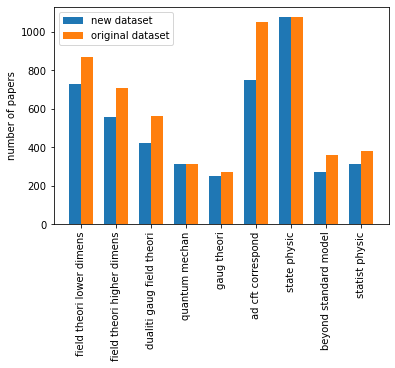

In [9]:
# Visualize the classes size
bar_width = 0.35
positions = np.arange(tags_number)

plt.bar(positions-bar_width/2,size_tag.values(),bar_width,label='new dataset')
plt.bar(positions+bar_width/2,full_df_size_tag,bar_width,label='original dataset')

plt.xticks(range(tags_number),size_tag.keys(),rotation='vertical')

plt.ylabel('number of papers')

plt.legend()
plt.show()

We are losing something, but not so much really. Might need to keep an eye on the *AdS-CFT correspondence* tag.

### Creating the dataset with fixed classes

We can now create the dataset out of the classes we have selected. 

In [10]:
df_tags = pd.DataFrame(columns=['title','abstract','keywords'])

for node in tags_tree.leaves():
    
    df_node = node.data.copy()
    df_node['keywords'] = node.tag
    
    df_tags = df_tags.append(df_node)

df_tags.reset_index(drop=True,inplace=True)
df_tags.to_pickle('./datasets/dataset_ft_classified.pkl')

## 3. Understanding the abstracts and titles

Let's see what kind of abstract/titles we are dealing with.

In [9]:
df_tags = pd.read_pickle('./datasets/dataset_ft_classified.pkl')
df_tags.sample(n=7)

,title,abstract,keywords
3429,Perturbation of atomic energy levels by a meta...,The energy level shifts of one-electron atomic...,state physic
2277,Entanglement between two disjoint universes,We use the replica method to compute the entan...,ad cft correspond
367,Bethe Ansatz and exact form factors of the O (...,We apply previous results on the O ( N ) Bethe...,field theori lower dimens
2139,\nO(5)×U(1) Electroweak gauge theory and the t...,The O (5)× U (1) electroweak gauge theory with...,gaug theori
1001,Constraining conformal field theories with a h...,We study unitary conformal field theories with...,field theori higher dimens
4605,Some remarks on Fröhlich's condition inP(φ)_2 ...,We derive Fröhlich's condition as the KMS cond...,statist physic
4501,Geometric realization of conformal field theor...,Conformal field theory on a family of Riemann ...,statist physic


### Understanding the abstracts

- how long are the abstract on average?
- how much equations are there?

In [10]:
labels = np.unique(df_tags['keywords'].to_numpy())

Let's see the abstract distribution,

In [11]:
abstract_length = df_tags['abstract'].apply(len).to_numpy()

min_length = min(abstract_length)
max_length = max(abstract_length)

mean_length = np.mean(abstract_length)
median_length = np.median(abstract_length)

print('The length of the abstracts ranges between {} and {} characters'.format(min_length,max_length))
print('The mean length is {}, the median is {}'.format(int(mean_length),int(median_length)))

The length of the abstracts ranges between 54 and 4558 characters
The mean length is 765, the median is 707


In [12]:
# the shortest abstract
df_tags.iloc[np.argmin(abstract_length)]['abstract']

'We prove in a rigorous way the statement of the title.'

Physicists are a rare breed...

In [13]:
# the longest abstract
df_tags.iloc[np.argmax(abstract_length)]['abstract']

"Dopo aver discusso tre vari approcci al formalismo canonico per una linea d'orizzonte in una metrica di background curvo si sviluppa un nuovo formalismo covariante. È basato sull'hamiltoniana che, per τ= s , è uguale alla massa propria e genera traslazioni nel tempo proprio s . Le, relazioni risultanti delle parentesi di Poisson sono equivalenti all'equazione geodesica. Nella teoria quantizzata la quadrivelocità classica è sostituita dall'operatore % MathType!MTEF!2!1!+-% feaafiart1ev1aaatuuDJXwAK1uy0Hwmaerbfv3ySLgzG0uy0Hgip5% wzamXvP5wqonvsaeHbfv3ySLgzaeXatLxBI9gBamXvP5wqSXMqHnxA% Jn0BKvguHDwzZbqehqvATv2CG4uz3bIuV1wyUbqehm0B1jxALjhiov% 2DaebbnrfifHhDYfgasaacH8qrps0lbbf9q8WrFfeuY-Hhbbf9v8qq% aqFr0xc9pk0xbba9q8WqFfea0-yr0RYxir-Jbba9q8aq0-yq-He9q8% qqQ8frFve9Fve9Ff0dmeaaciGacmaadaWabiqaeaqbaqaagaaakeaa% cqaHZoWzdaahaaWcbeqaaiabeY7aTbaaaaa!47C1! $$\\gamma ^\\mu $$ (matrici di Dirac); le equazioni risultanti di Heisenberg sono analoghi quantici dell'equazione di Papapetrou, per una partic

The abstract is written in many languages and has a weird math formatting. It might be good to:

- checking how many abstracts have latex equations.
- checking how many abstracts are written in english

Let's see the distribution of the abstracts,

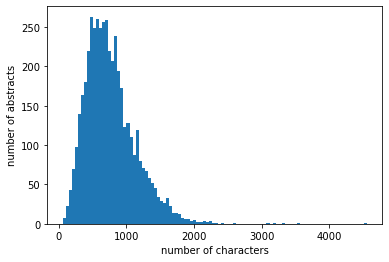

In [14]:
plt.hist(abstract_length,100)
plt.xlabel('number of characters')
plt.ylabel('number of abstracts')
plt.show()

### Let's count the number of equations in the abstract

We do not expect the number of equations to be correlated with the label, but it might be worth a try.

There are between 0 and 14 equations in each abstract.


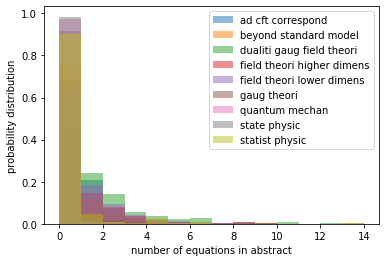

In [15]:
def find_equations(item):
    return len(re.findall('\$+.*?\$+', item))

# create a new column where we store the number of equations in the abstract
df_tags['number of eqs'] = df_tags['abstract'].apply(find_equations)

number_eqs = df_tags['number of eqs'].to_numpy()

max_number_eqs = max(number_eqs)
min_number_eqs = min(number_eqs)

print('There are between {} and {} equations in each abstract.'.format(min_number_eqs,max_number_eqs))

# Plot a histogram to understand if some category of papers have more/less equations than others
bins = np.arange(min_number_eqs,max_number_eqs+1,dtype=np.int)

for tag in labels:
    relevant = df_tags['keywords'] == tag
    number_eqs_tag = df_tags['number of eqs'][relevant].to_numpy()
    plt.hist(number_eqs_tag,bins,density=True,alpha=0.5,label=tag)
    
plt.xlabel('number of equations in abstract')
plt.ylabel('probability distribution')
plt.legend()
plt.show()

Let's also check how often the MathType incident occurs in the abstracts,

In [16]:
contains_mathtype = df_tags['abstract'].apply(lambda item : 'MathType' in item)
df_tags[contains_mathtype]

,title,abstract,keywords,number of eqs
1919,Canonical formalism and quantization of world-...,Dopo aver discusso tre vari approcci al formal...,quantum mechan,5


Only 1 MathType, good! Since anyway we are going to get rid of this one in the next step, let's ignore this for a moment.

### Check language of abstract

We use a package that recognise in which language a text has been written, (it takes a bit of time),

In [17]:
abstract_foreign = df_tags['abstract'].apply(at.is_foreign).to_numpy()
number_foreign = np.sum(abstract_foreign)

print('There are, potentially, {} foreign abstracts.'.format(number_foreign))

There are, potentially, 14 foreign abstracts.


Only a few are not in english, that's great... Let's check which one are not, we expect these to be those with multiple-language abstracts, and we can likely get rid of those.

In [18]:
df_tags['abstract'][abstract_foreign]

1288    Si continua lo studio di uno schema geometrico...
1729    Usando la tecnica delle sequenze spettrali, st...
1730    Мы исследуем секторы фадеева-Попова с зарядом ...
1895    Nondecomposable reducible time representations...
1901    В этой статье мы вычисляем амплитуду перехода ...
1919    Dopo aver discusso tre vari approcci al formal...
1925    A formulation of spinor analysis in space-time...
1927    As a model of gauge theory, we investigate a s...
1930    Si sottolinea che in una teoria che è invarian...
1935    It is shown how a procedure for analytic conti...
1936    Si presenta il formalismo completamente covari...
1944    The construction of a consistent multidimensio...
1945    The construction of a consistent multidimensio...
1952    In questo lavoro si discute la formulazione fu...
Name: abstract, dtype: object

In [19]:
foreign_indices = df_tags[abstract_foreign].index
df_tags.drop(foreign_indices,inplace=True)

### Understanding the titles

Pretty much is the same as before, let's see the lenght of the titles, 

In [20]:
title_length = df_tags['title'].apply(len).to_numpy()

min_length_title = min(title_length)
max_length_title = max(title_length)

mean_length_title = np.mean(title_length)
median_length_title = np.median(title_length)

print('The length of the abstracts ranges between {} and {} characters'.format(min_length_title,max_length_title))
print('The mean length is {}, the median is {}'.format(int(mean_length_title),int(median_length_title)))

The length of the abstracts ranges between 7 and 1249 characters
The mean length is 77, the median is 64


In [21]:
# the shortest title
df_tags.iloc[np.argmin(title_length)]['title']

'AGT/ℤ_2'

In [22]:
# the longest title
df_tags.iloc[np.argmax(title_length)]['title']

'Self-dual continuous series of representations for \n                \n                  \n                \n                \n                  \n                    \n                      U\n                      q\n                    \n                    \n                      \n                        s\n                        l\n                        \n                          2\n                        \n                      \n                    \n                  \n                \n                $$ {\\mathcal{U}}_q\\left(sl(2)\\right) $$\n               and \n                \n                  \n                \n                \n                  \n                    \n                      U\n                      q\n                    \n                    \n                      \n                        o\n                        s\n                        p\n                        \n                          \n                            1\n            

Let's check the distribution of the titles,

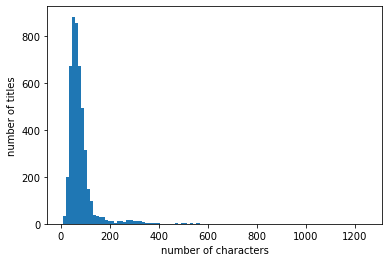

In [23]:
plt.hist(title_length,100)
plt.xlabel('number of characters')
plt.ylabel('number of titles')
plt.show()

I do not think there is much more to do here, since everything seems to be more or less fine and we just need to clean up the tiles a bit.

## 4. Cleaning title and abstracts

We can now use standard NLP techniques to clean up the abstract and title field, that is,

- remove math equations
- tokenize
- remove punctuation
- set in lowercase
- remove symbols
- remove stopwords
- perform stemming or lemmatization

### Cleaning the abstracts

Let's clean the abstracts first,

In [24]:
# lemmatizer for processing the abstracts
wn_lemmatizer = WordNetLemmatizer()

# let's clean the abstracts and save the cleand version in a new columns
df_tags['clean abs'] = df_tags['abstract'].apply(at.clean_text_lemmatize,args=(wn_lemmatizer,))

Let's see how many features we have created with the cleaning,

In [25]:
words = np.concatenate(df_tags['clean abs'].to_numpy())
unique_words = np.unique(words)

unique_words.size

15687

And the most common words,

In [26]:
word_frequency = Counter(words)
word_frequency.most_common(10)

[('theory', 6155),
 ('field', 3578),
 ('n', 2887),
 ('model', 2413),
 ('gauge', 2039),
 ('function', 1913),
 ('operator', 1821),
 ('2', 1694),
 ('quantum', 1689),
 ('result', 1688)]

Seems good. Let's more on to the titles now

### Cleaning the titles

Same drill as before, let's clean by removing equations, symbols, and lemmatizing

In [27]:
# let's clean the title and save the cleand version in a new columns
df_tags['clean title'] = df_tags['title'].apply(at.clean_text_lemmatize,args=(wn_lemmatizer,))

Let's see what are the unique words in the titles,

In [28]:
words_title = np.concatenate(df_tags['clean title'].to_numpy())
unique_words_title = np.unique(words_title)

unique_words_title.size

4681

In [29]:
word_frequency_title = Counter(words_title)
word_frequency_title.most_common(10)

[('theory', 1067),
 ('field', 656),
 ('quantum', 554),
 ('model', 362),
 ('gauge', 328),
 ('n', 244),
 ('conformal', 207),
 ('dimension', 189),
 ('duality', 169),
 ('function', 164)]

Pretty similar to what we had in the abstract, which makes sense.

### Check if cleaned abstracts or titles are empty

Just to be sure, let's check if the cleaned versions of title/abstract are all non-empty,

In [23]:
# check the titles
title_empty = df_tags['clean title'].apply(lambda item : len(item) == 0).to_numpy()
number_of_empty_titles = np.sum(title_empty)

# check the abstracts
abstract_empty = df_tags['clean abs'].apply(lambda item : len(item) == 0).to_numpy()
number_of_empty_abs = np.sum(abstract_empty)

print('There are {} missing titles and {} missing abstracts'.format(number_of_empty_titles,number_of_empty_abs))

There are 2 missing titles and 0 missing abstracts


Good, let's keep that since anyway we are going to join title and abstract together eventually.

One thing to check is the total number of unique terms between title and abstract,

In [51]:
len(word_frequency + word_frequency_title)

16264

And now let's save the cleaned data,

In [24]:
df_tags.to_pickle('./datasets/dataset_ft_cleaned.pkl')

## 5. Preprocessing of the data

Let's now map our dataset into a vectorized form. 2 ways to do this would be,

- *word count*: a sparse matrix whose rows are the items in the database and columns are the occurrence of a certain word. Can extend to n-grams
- *TF-IDF*: this is the term frequency x inverse document frequency (increases as the term is more frequent in the document, but decreases if the term is frequent everywhere in the corpus).

We'll go for the latter since there are a lot of terms that likely appear in many abstracts but are not very informative of the kind of field the paper is concerned about (for example, "study" or "theory").

In [3]:
df_clean = pd.read_pickle('./datasets/dataset_ft_cleaned.pkl')

df_clean.tail()

,title,abstract,keywords,number of eqs,clean abs,clean title
4681,Some remarks about the localization of states ...,For the case of a field theory with a nuclear ...,statist physic,0,"[case, field, theory, nuclear, space, test, fu...","[remark, localization, state, quantum, field, ..."
4682,A proof of the crossing property for two-parti...,"In the framework of the ℒ. l . Z . formalism, ...",statist physic,0,"[framework, l, z, formalism, crossing, propert...","[proof, crossing, property, two-particle, ampl..."
4683,On the connection between the LSZ and Wightman...,The LSZ asymptotic condition and the Yang-Feld...,statist physic,0,"[lsz, asymptotic, condition, yang-feldman, equ...","[connection, lsz, wightman, quantum, field, th..."
4684,On the vacuum state in quantum field theory. II,"We want to construct, for every local irreduci...",statist physic,2,"[want, construct, every, local, irreducible, q...","[vacuum, state, quantum, field, theory, ii]"
4685,A theorem concerning the positive metric,It is proved that if the n -point correlation ...,statist physic,0,"[proved, n, -point, correlation, function, sys...","[theorem, concerning, positive, metric]"


We'll try to add the title to the abstract, as if the two were the same. It would be interesting to see if we should treat them independently, for example by weighting the terms in the title more.

In [4]:
labels = np.unique(df_clean['keywords'].to_numpy())

### Training and test split

As a first step before creating the bag-of-words, let's split the datset into a test set and a training set. Let's use a 70/30 split.

In [5]:
# just so we are sure we can reproduce the splitting
seed = 1863

# split into training and test
df_train = df_clean.sample(frac=0.7,random_state=seed)
df_test = df_clean.drop(df_train.index)

Let's check that training and test have a comparable proportion of class items,

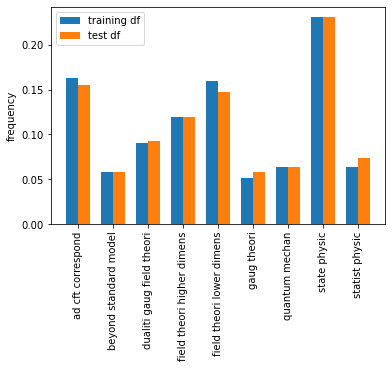

In [6]:
# Compute relative frequency of labels in traning and test datasets
bars_train = at.get_frequency_df(df_train,labels)
bars_test = at.get_frequency_df(df_test,labels)

pos = np.arange(len(labels))

# Visualize the classes size
bar_width = 0.35

plt.bar(pos-bar_width/2,bars_train,bar_width,label='training df')
plt.bar(pos+bar_width/2,bars_test,bar_width,label='test df')

plt.xticks(pos,labels,rotation='vertical')

plt.ylabel('frequency')

plt.legend()
plt.show()

The split seems fine, we can proceed.

### Bag-of-words vectorization and TF-IDF

Let's create the Bag-of-Words matrix, and consider the TF-IDF,

In [7]:
corpus_train = (df_train['clean title']+df_train['clean abs']).to_numpy()
corpus_test = (df_test['clean title']+df_test['clean abs']).to_numpy()

# This is needed since we did all the pre-processing outside sklearn
tokens_to_string = np.vectorize(lambda word_list: ' '.join(word_list))

corpus_train = tokens_to_string(corpus_train)
corpus_test = tokens_to_string(corpus_test)

# Let's create the vectorized matrix (while splitting the corpus back into tokens)
vectorizer = TfidfVectorizer(analyzer=str.split)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

print('The training dataset has {} items and {} features'.format(*X_train.shape))
print('The test datatset has {} items'.format(X_test.shape[0]))

The training dataset has 3270 items and 13602 features
The test datatset has 1402 items


In [8]:
# get the response vector for training and test
y_train = df_train['keywords'].to_numpy()
y_test = df_test['keywords'].to_numpy()

# and the name of the features
features = vectorizer.get_feature_names()

Since cross-validation is quite demanding, we save the training set so that we can do CV on a different machine.

In [8]:
# Save training set
save_npz('./datasets/vectorized/X_train',X_train)
np.save('./datasets/vectorized/y_train',y_train)

# Save test set
save_npz('./datasets/vectorized/X_test',X_test)
np.save('./datasets/vectorized/y_test',y_test)

# Save the feature names
np.save('./datasets/vectorized/features',features)

### Base-line model

Before starting training any model, let's assume that we always guess the most populated category among the 9 we have. What accuracy do we get? That will be our crude base-line model.

In [15]:
most_common_label, number_common_label = Counter(y_test).most_common(1)[0]
baseline_accuracy = number_common_label/len(y_test)

print('The most common label is "{}"'.format(most_common_label))
print('A model that always predict this label has accuracy {:.2f}'.format(baseline_accuracy))

The most common label is "state physic"
A model that always predict this label has accuracy 0.23


## 6. Training models

We are going to use a few different models for classification, and see which one is better for this situation.

- ensemble learners
    - random forest
    - boosting of trees
- support vector machine
- logistic regression

Let's first load the training and test sets,

In [2]:
X_train = load_npz('./datasets/vectorized/X_train.npz')
y_train = np.load('./datasets/vectorized/y_train.npy',allow_pickle=True)

X_test = load_npz('./datasets/vectorized/X_test.npz')
y_test = np.load('./datasets/vectorized/y_test.npy',allow_pickle=True)

features = np.load('./datasets/vectorized/features.npy',allow_pickle=True)

labels = np.unique(y_train)

### 6.a. Random Forests

Let's create an ensemble of trees built out of bootstrapped samples, where we reduce the correlations between trees by selecting only m < p features for building the tree. The trees composing the ensemble are fully grown trees (differently from boosting).

In [3]:
model_RF = load('./models/RF_model.joblib')

### Hyperparameters selection

We use out-of-bag samples to compute the generalization error and select the best parameters to use, where the main parameter we are interested to optimize are,

- number of trees (how many trees we use in our ensemble)
- number of features (the number of features to sample for creating new split while growing trees).

We run the selection on a different machine, over the following range of parameters,

In [8]:
max_features_rf = np.arange(50,750+1,50,dtype=np.int)

n_estimators_rf = [10,100,200,400,600,800,1000,1200,1400,1600]

The results are shown below,

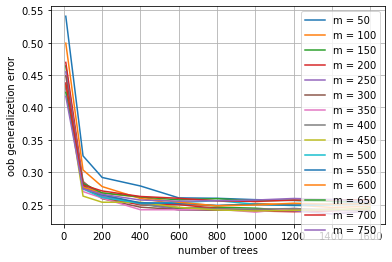

In [11]:
df_oob_RF = pd.read_pickle('./cross-val/random_forest/oob_results.pkl')

for m in max_features_rf:
        
    # we select the scores for a given choice of max features
    relevant_df = df_oob_RF[df_oob_RF['max_features'] == m]
    relevant_df.sort_values('n_estimators')

    obb_error = relevant_df['misc_error'].to_numpy()

    # And we plot the CV results with error bars
    plt.plot(n_estimators_rf,obb_error,label='m = {}'.format(m))
    plt.xlabel('number of trees')
    plt.ylabel('oob generalizetion error')
    plt.grid()
    plt.legend()
plt.show()

In [18]:
df_oob_RF.iloc[df_oob_RF['misc_error'].argmin()]

max_features     250.000000
n_estimators    1400.000000
misc_error         0.235474
Name: 48, dtype: float64

### Model evaluation

Let's see the performance of the obtained classifier over the test set. First, let's select the model,

In [19]:
model_RF = RandomForestClassifier()

model_RF.set_params(max_features=250)
model_RF.set_params(n_estimators=1400)

model_RF.set_params(random_state=8363)
model_RF.set_params(n_jobs=-1)

RandomForestClassifier(max_features=250, n_estimators=1400, n_jobs=-1,
                       random_state=8363)

Then we train it and visualize its performances,

In [20]:
model_RF.fit(X_train,y_train)

RandomForestClassifier(max_features=250, n_estimators=1400, n_jobs=-1,
                       random_state=8363)

                            precision    recall  f1-score   support

         ad cft correspond       0.64      0.92      0.76       217
     beyond standard model       0.89      0.90      0.90        82
 dualiti gaug field theori       0.71      0.39      0.50       130
field theori higher dimens       0.79      0.48      0.59       168
 field theori lower dimens       0.52      0.47      0.49       207
               gaug theori       0.74      0.78      0.76        82
            quantum mechan       0.88      0.93      0.91        89
              state physic       0.85      1.00      0.92       323
            statist physic       0.86      0.73      0.79       104

                  accuracy                           0.75      1402
                 macro avg       0.77      0.73      0.74      1402
              weighted avg       0.75      0.75      0.73      1402



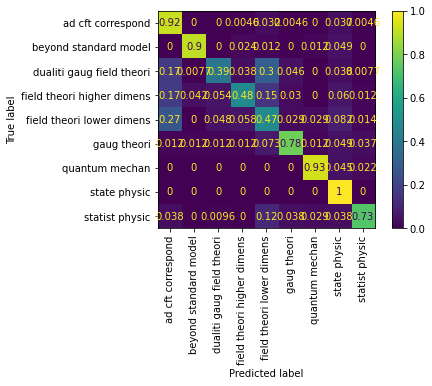

In [22]:
# Let's check the performance of the classifier
performance_RF = classification_report(y_test, model_RF.predict(X_test))
print(performance_RF)

# Let's visualize the confusion matrix for this classifier
plot_confusion_matrix(model_RF,X_test,y_test,xticks_rotation='vertical',normalize='true')
plt.show()

The classifier is doing a good job with a few classes,

- beyond standard model (F1=0.90)
- quantum mechan  (F1=0.91)
- state physic  (F1=0.92)

Its predictions are decent for the following classes as well,

- ad cft correspond (F1=0.76)
- gaug theori (F1=0.76)
- statist physic (F1=0.79)

while it is doing not so great with the remaining ones

- dualiti gaug field theori (F1=0.50)
- field theori higher dimens (F1=0.59)
- field theori lower dimens (F1=0.49)

We could probably have predicted this since the ones where the model is doing badly are those that have the most in common. 

Before moving on, we save the trained model,

In [23]:
dump(model_RF, './models/RF_model.joblib')

['./models/RF_model.joblib']

### Feature importance

Let's also look at the most important features for the split, using *Gini importance*; at each node, a tree splits to purify the samples in the child nodes. Average the increase in purity and return the features that, when used for splitting, achieve the best purity.

Note, we could also use *permutation importance*, where we permute a feature column and compute score using a trained model. The lower the score is compared to the non-permuted case, the higher the importance of that feature. However, due to the large number of features, this is computationally demanding, and we'll postpone it to another time.

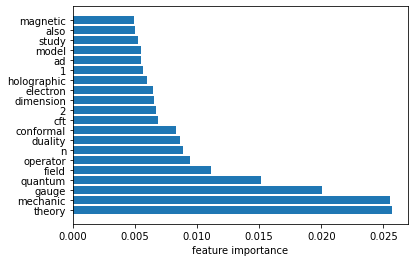

In [24]:
# Gini importance (this is already provided by the RF model)
gini_importance_RF = list(zip(model_RF.feature_importances_,features))
gini_importance_RF.sort(reverse=True)

at.plot_feature_importance(gini_importance_RF)
plt.show()

Some of the features selected make sense, others not so much. For example,

- "gauge", "duality", "ad(s)", "cft", "holographic" are all expected to be important for differentiate high-energy physics from statistic physics or quantum mechanics paper.
- "also" and "study" should not be important to differentiate between topics.

### 6.b. Gradient Boosting

Another ensemble learner, this one works on the high bias of the single, weak learners, to achieve a better accuracy (this is different from the random forests, where the trees are fully grown and we are reducing the variance by averaging). The idea is to produce a sequence of stomps (small trees), and take a collective weighted vote.

In [4]:
model_GB = load('./models/GB_model.joblib')

### Hyperparameters selection

We use 5-Fold CV to select the best parameters to use, where the main parameter we are interested to optimize are,

- learning rate (this is going to reduce the contribution of each new tree we fit, useful for avoiding overfitting - the alternative is early stopping)
- number of trees (how many trees we use in our ensemble - it is linked to the learning rate)
- max depth of each tree (small trees are used in boosting, and the depth regulate the order of interaction between features)

If we are going to use stochastic gradient boosting, we could also select the fraction of samples to use, and that would be another hyperparameter to fit. This time we do not use stochastic gradient boosting though.

As a loss, we go for the standard one (deviance) since it is less sensitive to outliers than the exponential one used in AdaBoost.

We run CV on a different machine, over the following range of parameters,

In [3]:
learning_rate_boosting = [1e-2,5e-2,1e-1,5e-1]
max_depth_boosting = [2,3,4,5,6]

n_estimators_boosting = [10,100,200,400,600,800,1000,1200,1400,1600]

The CV results are shown below,

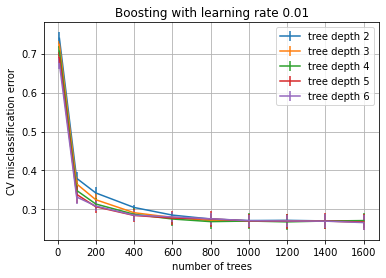

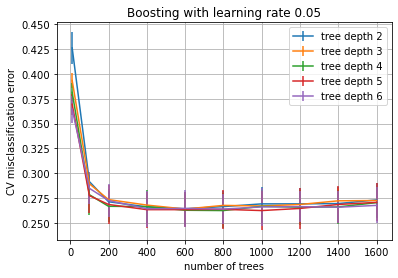

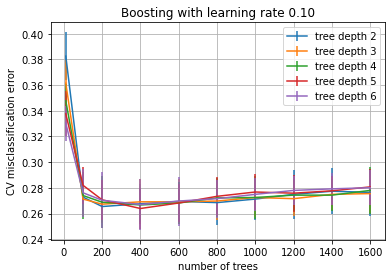

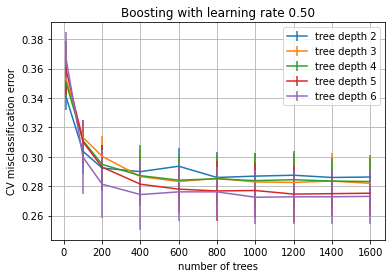

In [4]:
df_CV_boosting = pd.read_pickle('./cross-val/boosting/cross_val_results.pkl')

for lr in learning_rate_boosting:
    for dpt in max_depth_boosting:
        
        # we select the scores for a given choice of learning rate and tree depth
        bool_lr = df_CV_boosting['param_learning_rate'] == lr
        bool_dpt = df_CV_boosting['param_max_depth'] == dpt
        
        relevant_df = df_CV_boosting[np.logical_and(bool_lr,bool_dpt)]
        relevant_df.sort_values('param_n_estimators')
        
        cv_error = 1 - relevant_df['mean_test_score'].to_numpy()
        cv_se = relevant_df['std_test_score'].to_numpy()
        
        # And we plot the CV results with error bars
        plt.errorbar(n_estimators_boosting,cv_error,yerr=cv_se,label='tree depth {}'.format(dpt))
        plt.title('Boosting with learning rate {:.2f}'.format(lr))
        plt.xlabel('number of trees')
        plt.ylabel('CV misclassification error')
        plt.grid()
        plt.legend()
    plt.show()

The oprimal values for the parameters are,

In [5]:
df_CV_boosting[df_CV_boosting['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,577.54816,2.782359,0.157049,0.001481,0.05,5,1000,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.770642,0.724771,0.732416,0.714067,0.744648,0.737309,0.019423,1


### Model evaluation

Let's see the performance of the obtained classifier over the test set. First, let's select the model,

In [6]:
model_GB = GradientBoostingClassifier()

model_GB.set_params(learning_rate=0.05)
model_GB.set_params(max_depth=5)
model_GB.set_params(n_estimators=1000)

model_GB.set_params(random_state=2764)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=1000,
                           random_state=2764)

Then we train it and visualize its performances,

In [ ]:
model_GB.fit(X_train, y_train)

                            precision    recall  f1-score   support

         ad cft correspond       0.70      0.78      0.73       217
     beyond standard model       0.93      0.80      0.86        82
 dualiti gaug field theori       0.71      0.53      0.61       130
field theori higher dimens       0.74      0.58      0.65       168
 field theori lower dimens       0.44      0.55      0.49       207
               gaug theori       0.81      0.66      0.72        82
            quantum mechan       0.82      0.93      0.87        89
              state physic       0.91      0.98      0.95       323
            statist physic       0.74      0.62      0.67       104

                  accuracy                           0.74      1402
                 macro avg       0.76      0.71      0.73      1402
              weighted avg       0.75      0.74      0.74      1402



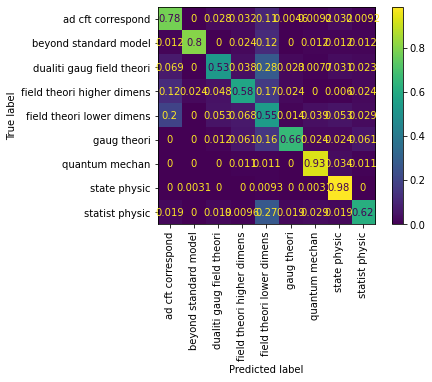

In [20]:
# Let's check the performance of the classifier
performance_GB = classification_report(y_test, model_GB.predict(X_test))
print(performance_GB)

# Let's visualize the confusion matrix for this classifier
plot_confusion_matrix(model_GB,X_test,y_test,xticks_rotation='vertical',normalize='true')
plt.show()

We see a similar situation as we did with the Random Forest classifier. Specifically, the model can well-differentiate

- beyond standard model (F1 = 0.86)
- quantum mechan (F1 = 0.87)
- state physic  (F1 = 0.95)

The model does a decent job with

- ad cft correspond  (F1 = 0.73)
- gaug theori (F1 = 0.72)

While its performance is lower on

- dualiti gaug field theori (F1 = 0.61)
- field theori higher dimens (F1 = 0.65)
- field theori lower dimens (F1 = 0.49)
- statist physic (F1 = 0.67)

It is worth noting that 3 of the categories where the model struggles might indeed have overlapping topics, which would explain the observed performance.

Finally, we save the model so we do not have to train it again,

In [21]:
dump(model_GB, './models/GB_model.joblib')

['./models/GB_model.joblib']

### Feature importance

Similar to Random Forests, Boosting provides a feature importance vector, built out of the increase in purity due to a split wrt a given feature. We show below the most important features as measured via Gini importance,

Finally, we save the model so we do not have to train it again,

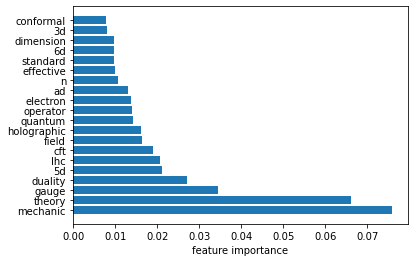

In [4]:
# Gini importance
gini_importance_GB = list(zip(model_GB.feature_importances_,features))
gini_importance_GB.sort(reverse=True)

at.plot_feature_importance(gini_importance_GB)

Even if the Gradient Boosting method achieves similar performance to the Random Forest model, it is interesting to notice that the first few features picked up by the former seems to be more relevant than those picked up by the latter. In particular, we do not see features such as "study" and "also" appearing here, while this occurs in the Random Forest model.

### 6.c. Support Vector Machine

Instead of using trees and ensemble learners, we try here to use an SVM creating a decision boundary between the different classes. Since we are already working with a large number of features, we use a linear Kernel. Since we deal with a multi-class problem, the SVM is trained in a one-vs-rest fashion.

In [5]:
model_SVM = load('./models/SVM_model.joblib')

### Hyperparameters selection

We use 5-Fold CV to select the best parameters to use, where the main parameter we are interested to optimize are,

- regularization parameter (the weights of each feature is regularized with an l2 penalty)
- intercept scaling (this is due to how the algorithm is implemented in sklearn - the intercept is regularized as well, so we might increase the input value to reduce this effect)

We optimize the hinge loss function to obtain the optimal separation between classes.

We run CV on a different machine, over the following range of parameters,

In [ ]:
param_C = np.arange(0.1,10.1,0.1)
param_intercept_scaling = [1,2,3]

The results of cross-validation are the following one,

In [104]:
df_CV_svm = pd.read_pickle('./cross-val/svm/cross_val_results.pkl')

df_CV_svm[df_CV_svm['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_intercept_scaling,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
49,0.188865,0.008051,0.001082,0.000023,1.7,2,"{'C': 1.7000000000000002, 'intercept_scaling': 2}",0.785933,0.787462,0.7737,0.795107,0.781346,0.784709,0.007067,1
50,0.381363,0.012827,0.001111,0.000029,1.7,3,"{'C': 1.7000000000000002, 'intercept_scaling': 3}",0.785933,0.787462,0.7737,0.795107,0.781346,0.784709,0.007067,1


Two values of the intercept_scaling give the optimal CV error.

### Model evaluation

Let's see the performance of the obtained classifier over the test set. First, let's select the model,

In [105]:
model_SVM = LinearSVC()

model_SVM.set_params(loss='hinge')
model_SVM.set_params(C=1.7)
model_SVM.set_params(intercept_scaling=2)

model_SVM.set_params(random_state=1847)

LinearSVC(C=1.7, intercept_scaling=2, loss='hinge', random_state=1847)

Then we train it and visualize its performances,

In [107]:
model_SVM.fit(X_train, y_train)

LinearSVC(C=1.7, intercept_scaling=2, loss='hinge', random_state=1847)

                            precision    recall  f1-score   support

         ad cft correspond       0.68      0.85      0.75       217
     beyond standard model       0.90      0.98      0.94        82
 dualiti gaug field theori       0.67      0.58      0.62       130
field theori higher dimens       0.73      0.61      0.66       168
 field theori lower dimens       0.58      0.52      0.55       207
               gaug theori       0.77      0.71      0.74        82
            quantum mechan       0.91      0.91      0.91        89
              state physic       0.93      0.98      0.95       323
            statist physic       0.83      0.77      0.80       104

                  accuracy                           0.77      1402
                 macro avg       0.78      0.77      0.77      1402
              weighted avg       0.77      0.77      0.77      1402



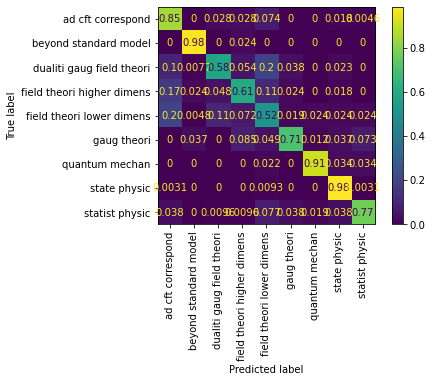

In [108]:
# Let's check the performance of the classifier
performance_SVM = classification_report(y_test, model_SVM.predict(X_test))
print(performance_SVM)

# Let's visualize the confusion matrix for this classifier
plot_confusion_matrix(model_SVM,X_test,y_test,xticks_rotation='vertical',normalize='true')
plt.show()

This model seems to provide a marginal improvement in accuracy compared to the ensemble learner models. Where the model performs poorly is on the same 3 classes that are problematic for the ensemble learner as well.

Finally, we save the model so we do not have to train it again,

In [109]:
dump(model_SVM, './models/SVM_model.joblib')

['./models/SVM_model.joblib']

### Feature importance

For general SVM it is difficult to assign feature importance since the features are mapped into an (infinite) dimensional HS by the kernel trick. However, we are here using linear SVM, so the weights of the model give a separating hyperplane in the feature space.

We can then get the feature importance by considering the absolute value of each weight component (after normalizing the vector).

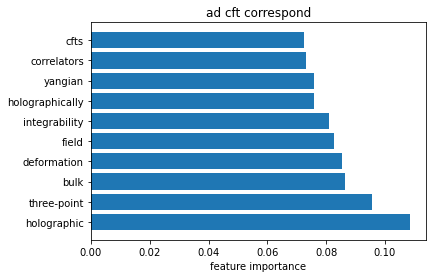

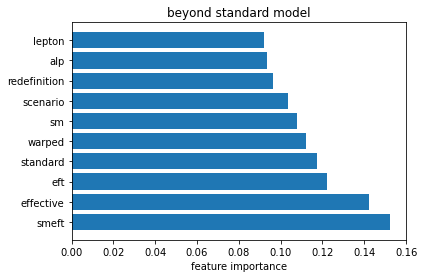

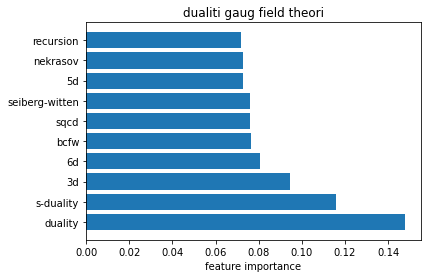

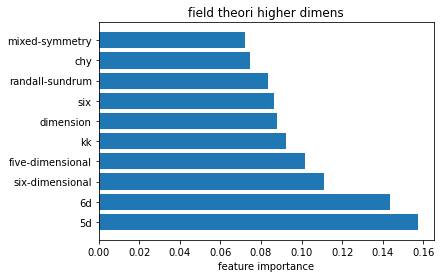

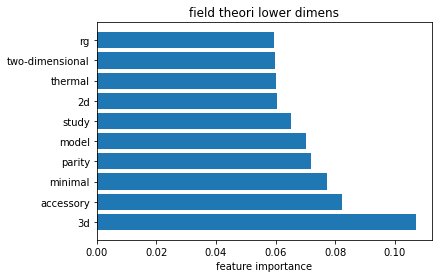

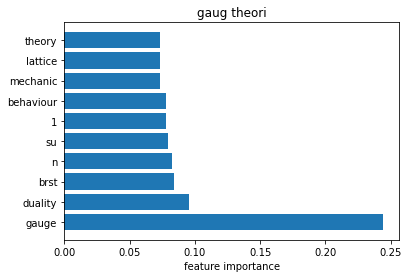

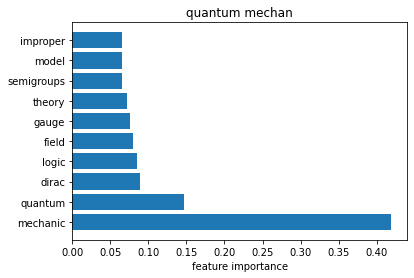

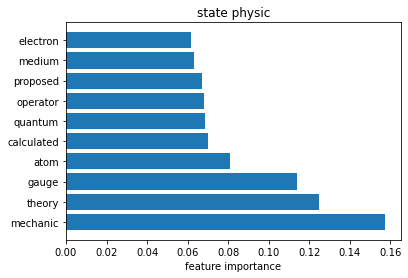

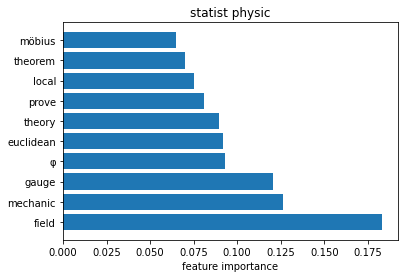

In [20]:
X_std = np.std(X_train.toarray(),axis=0).shape

# We have weights for each classes (since each class was trained as oVr)
for label,weight in zip(model_SVM.classes_,model_SVM.coef_):

    # Weight contribution (absolute value, normalized)
    weight = X_std*np.abs(weight)/nla.norm(X_std*weight)
    
    # Order the feature by importance
    class_importance = sorted(zip(weight,features),reverse=True)
    
    # Plot the feature importance for each class
    at.plot_feature_importance(class_importance,number_features=10)
    plt.title(label)
    plt.show()

The plots are quite interesting, see for example how for the *ads-cft correspondance* we have that important features include "holographic", "bulk", "deformation", "cfts".

### 6.d. Logistic regression

As a final model for classification, we use logistic regression. Since the number of features is large, we use l1 regularization, to select the relevant features. Logistic regression naturally allows for a multi-class framework, so we do not need to use a one-vs-rest approach as we did for the SVM.

In [6]:
model_LR = load('./models/LR_model.joblib')

### Hyperparameters selection

We use 5-Fold CV to select the best parameters to use, where the main parameter we are interested to optimize are,

- regularization parameter (the weights of each feature is regularized with an l1 penalty)
- intercept scaling (this is due to how the algorithm is implemented in sklearn - the intercept is regularized as well, so we might increase the input value to reduce this effect)

The algorithm minimizes the multinomial deviance (or maximizes the log-likelihood).

We run CV on a different machine, over the following range of parameters,

In [32]:
param_C = [1e2,2e2,5e2,1e3,2e3,5e3,1e4,2e4,5e4]

The results of cross-validation are described in the following plot,

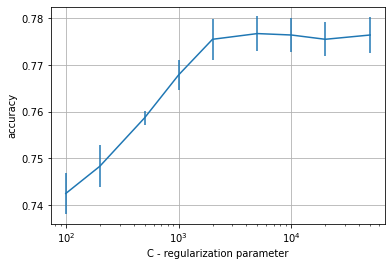

In [33]:
df_CV_logistic = pd.read_pickle('./cross-val/logistic_regression/cross_val_results.pkl')

cv_accuracy = df_CV_logistic['mean_test_score']
cv_std_err = df_CV_logistic['std_test_score']/np.sqrt(5)

plt.errorbar(param_C,cv_accuracy,yerr=cv_std_err)
plt.xscale('log')
plt.xlabel('C - regularization parameter')
plt.ylabel('accuracy')
plt.grid()

Using the one-standard-error rule, we can select the parameter whose mean accuracy is within 1 standard error from the maximum achieved by the curve, and such that the complexity of the model is lower. The complexity increases monotonically in the C parameter, so we'll select C = 2000.

### Model evaluation

Let's see the performance of the obtained classifier over the test set. First, let's select the model, according to the best hyperparameters found

In [39]:
model_LR = LogisticRegression()

model_LR.set_params(penalty='l1')
model_LR.set_params(C=2000)
model_LR.set_params(solver='saga')
model_LR.set_params(max_iter=5000)
model_LR.set_params(multi_class='multinomial')

model_LR.set_params(random_state=3863)
model_LR.set_params(n_jobs=-1)

LogisticRegression(C=2000, max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   penalty='l1', random_state=3863, solver='saga')

Then we train it and visualize its performances,

In [40]:
model_LR.fit(X_train, y_train)

LogisticRegression(C=2000, max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   penalty='l1', random_state=3863, solver='saga')

                            precision    recall  f1-score   support

         ad cft correspond       0.70      0.81      0.75       217
     beyond standard model       0.89      0.94      0.91        82
 dualiti gaug field theori       0.62      0.55      0.58       130
field theori higher dimens       0.70      0.61      0.65       168
 field theori lower dimens       0.57      0.58      0.58       207
               gaug theori       0.85      0.70      0.77        82
            quantum mechan       0.88      0.92      0.90        89
              state physic       0.94      0.98      0.96       323
            statist physic       0.85      0.79      0.82       104

                  accuracy                           0.77      1402
                 macro avg       0.78      0.76      0.77      1402
              weighted avg       0.77      0.77      0.77      1402



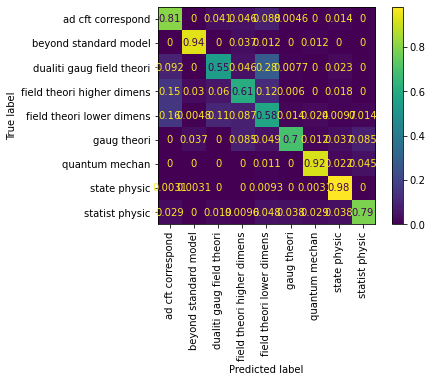

In [41]:
# Let's check the performance of the classifier
performance_LR = classification_report(y_test, model_LR.predict(X_test))
print(performance_LR)

# Let's visualize the confusion matrix for this classifier
plot_confusion_matrix(model_LR,X_test,y_test,xticks_rotation='vertical',normalize='true')
plt.show()

We achieve similar performance to those obtained via the SVM. These linear methods seem to outperform the ensemble learners for this dataset.

Finally we save the model so we do not have to train it again,

In [42]:
dump(model_LR, './models/LR_model.joblib')

['./models/LR_model.joblib']

### Feature importance

Here, it might be nice to use the Wald test to check which coefficients are significantly different from 0. Unfortunately, the Wald test (like other statistical tests such as the likelihood ratio) requires that our estimate of the coefficient is obtained via an unconstrained max-likelihood estimator. This is **not** the case in this setting, since we are using an l1-penalty.

Possible approaches to get the statistical significance of the coefficients when sparsity is enforced can be found in "Statistical Learning with Sparsity" T. Hastie et al. An additional problem is that most of these methods focus on linear regression with l1 penalty, rather than logistic regression. One can probably map from one to the other (with some assumptions), but this seems to be a non-trivial task.

## 7. Model evaluation

We'd now like to compare the accuracy of the different models, to understand which pair of models are significantly different from one another. Since the test data are the same for all the models, the test errors are correlated and one cannot use a two-sample t-test.

Instead, we will perform the [McNemar test](https://en.wikipedia.org/wiki/McNemar%27s_test); given two models M1 and M2, we build the table

| M1 \ M2     | Correct     |  Error       |
| ----------- | ----------- |  ----------- |
| Correct     | a           |  b           |
| Error       | c           |  d           |

The *null hp* is that the probability of correct and error are the same for the two models,

- $p(correct|M1) = p_a + p_b = p_a + p_c = p(correct|M1)$
- $p(error|M1) = p_c + p_d = p_b + p_d = p(error|M1)$

Equivalently, the null hp is $p_b = p_c$, and the alternative hp is that they are different (and therefore one of the models is significantly different from the other).

The test statistics is $(b-c)^2/(b+c)$, with a Chi-square distribution with 1 dof.

In [7]:
# List of all models trained in the notebook
models = [model_RF, model_GB, model_SVM, model_LR]
names = ['Random Forest','Gradient Boosting', 'Support Vector Machine', 'Logistic Regression']

# Comparison via McNemar test
at.models_comparison(models,names,X_test,y_test)

Null hypothesis (the two tests are equivalent) is rejected for p_val < 0.050
---
M1 = Logistic Regression vs M2 = Random Forest

+---------+------+-----+---------+
|  M1\M2  |  C2  |  E2 | sum row |
+---------+------+-----+---------+
|    C1   | 931  | 153 |   1084  |
|    E1   | 117  | 201 |   318   |
| sum col | 1048 | 354 |   1402  |
+---------+------+-----+---------+

Null hypothesis rejected - models are significantly different (p_val= 0.028)
---
M1 = Logistic Regression vs M2 = Gradient Boosting

+---------+------+-----+---------+
|  M1\M2  |  C2  |  E2 | sum row |
+---------+------+-----+---------+
|    C1   | 924  | 160 |   1084  |
|    E1   | 110  | 208 |   318   |
| sum col | 1034 | 368 |   1402  |
+---------+------+-----+---------+

Null hypothesis rejected - models are significantly different (p_val= 0.002)
---
M1 = Logistic Regression vs M2 = Support Vector Machine

+---------+------+-----+---------+
|  M1\M2  |  C2  |  E2 | sum row |
+---------+------+-----+---------+
|  